Кумулятивний відсоток кількості поїздок по годинах доби за останній тиждень

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

spark = SparkSession.builder \
    .appName("SimpleApp") \
    .getOrCreate()



your 131072x1 screen size is bogus. expect trouble
25/04/15 12:54:56 WARN Utils: Your hostname, DESKTOP-DP2FLCF resolves to a loopback address: 127.0.1.1; using 172.22.104.161 instead (on interface eth0)
25/04/15 12:54:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/15 12:55:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/15 12:55:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/15 12:55:07 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/04/15 12:55:07 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
df_fare_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_fare_1.csv")
df_trip_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_data_1.csv")

In [4]:
for column in df_fare_init.columns:
    df_fare_init = df_fare_init.withColumnRenamed(column, column.strip().replace(" ", "_"))

In [5]:
from pyspark.sql.functions import lit
df_trip = df_trip_init.filter(
    (col("passenger_count") > 0) & (col("passenger_count") <= 10) &
    (col("trip_time_in_secs") > 0) &
    (col("trip_distance") > 0) &
    (col("pickup_latitude").between(40.5, 41.0)) &
    (col("dropoff_latitude").between(40.5, 41.0)) &
    (col("pickup_longitude").between(-74.5, -73.0)) &
    (col("dropoff_longitude").between(-74.5, -73.0)) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

df_fare = df_fare_init.filter(
    (col("fare_amount") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") >= 0) &
    ((col("fare_amount") > 0) | (col("payment_type") == "NOC")) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, hour, date_format, to_date, count,avg, sum as Fsum, max as Fmax, date_sub, round as Fround, lit

last_week_start = lit("2013-01-27")

df_filtered = df_trip.withColumn("trip_date", to_date("pickup_datetime")) \
    .filter(col("trip_date") >= last_week_start - expr("INTERVAL 7 DAYS"))

df_with_time = df_filtered.withColumn(
    "hour", hour("pickup_datetime")
).withColumn(
    "weekday", date_format(col("trip_date"), "EEEE")
)

df_grouped = df_with_time.groupBy("weekday", "hour").agg(
    count("*").alias("trip_count")
)

window_spec = Window.partitionBy("weekday").orderBy("hour")

df_cumulative = df_grouped.withColumn(
    "cum_trips", Fsum("trip_count").over(window_spec)
)

total_trips_per_day = df_grouped.groupBy("weekday").agg(
    Fsum("trip_count").alias("total_day_trips")
)

df_joined = df_cumulative.join(total_trips_per_day, on="weekday", how="left").withColumn(
    "cum_percent", Fround(col("cum_trips") / col("total_day_trips") * 100, 2)
)

In [ ]:
from pyspark.sql.functions import col, hour, date_format, count,avg, sum as Fsum, max as Fmax, date_sub, round as Fround, lit

df_pivot = df_joined.groupBy("hour").pivot("weekday", [
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
]).agg(Fround(avg("cum_percent"), 2))

df_sorted = df_pivot.orderBy("hour")

df_sorted.show(24, truncate=False)


+----+------+-------+---------+--------+------+--------+------+
|hour|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday|
+----+------+-------+---------+--------+------+--------+------+
|0   |3.98  |1.68   |2.17     |2.38    |3.44  |5.07    |7.05  |
|1   |6.81  |2.62   |3.37     |3.76    |5.54  |9.29    |13.24 |
|2   |8.77  |3.21   |4.09     |4.62    |6.91  |12.75   |18.55 |
|3   |10.15 |3.62   |4.58     |5.17    |7.83  |15.32   |22.71 |
|4   |11.23 |4.06   |5.06     |5.68    |8.57  |16.91   |25.28 |
|5   |12.14 |4.91   |5.89     |6.47    |9.48  |17.69   |26.36 |
|6   |13.62 |7.5    |8.43     |8.83    |11.83 |18.56   |27.29 |
|7   |15.8  |12.44  |13.4     |13.36   |16.53 |19.96   |28.41 |
|8   |19.46 |18.58  |19.43    |18.88   |22.39 |22.24   |30.11 |
|9   |23.87 |24.27  |25.19    |24.15   |27.93 |25.5    |32.66 |
|10  |28.44 |29.21  |30.14    |28.76   |32.72 |29.43   |36.23 |
|11  |33.52 |33.96  |34.93    |33.29   |37.42 |33.99   |40.57 |
|12  |39.08 |38.87  |40.01    |38.01   |

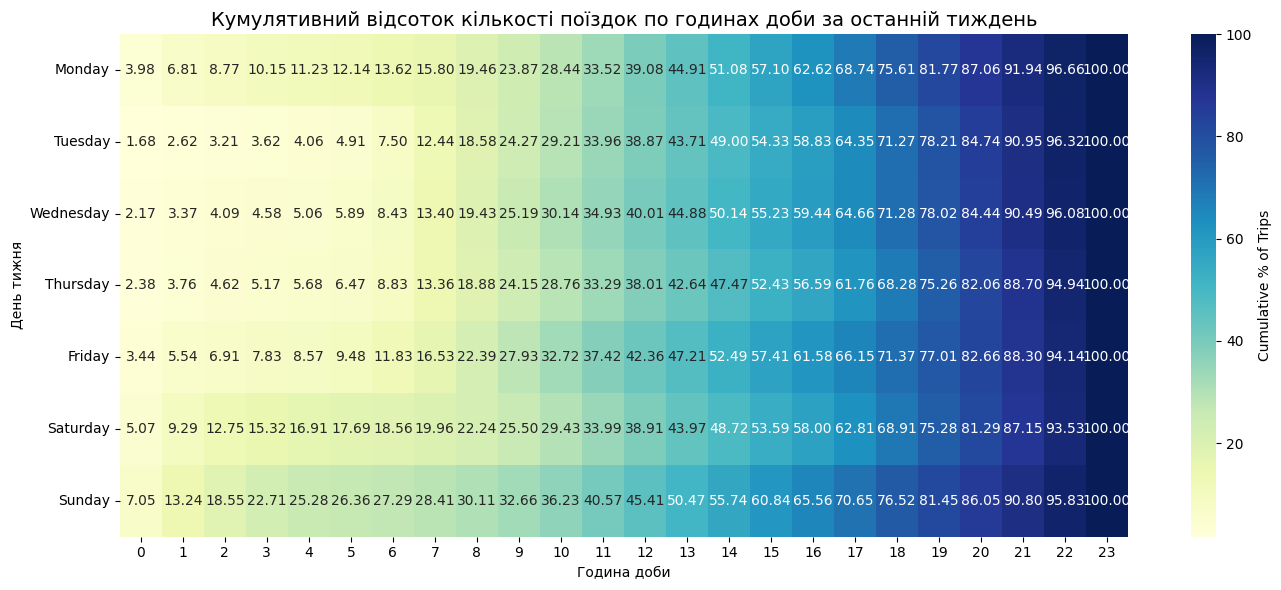

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = df_sorted.toPandas()

pandas_df = pandas_df.set_index("hour")

plt.figure(figsize=(14, 6))
sns.heatmap(pandas_df.transpose(), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Cumulative % of Trips'})

plt.title("Кумулятивний відсоток кількості поїздок по годинах доби за останній тиждень", fontsize=14)
plt.xlabel("Година доби")
plt.ylabel("День тижня")
plt.tight_layout()
plt.show()
